# Differentiable Physics VIII: Incompressible Navier Stokes Vortex Stream Function Approach

## Navier Stokes Equations

We limit the scope of the solver with the following constraints:

- We use the conservative form of the equations, meaning we are looking at a volume which is fixed in space and the fluid is moving through it.
- We use a 2D grid based approach, where each cell in the grid represents a volume element and has size $\Delta x \times \Delta y$.
- The fluid is incompressible. This means that the density $\rho$ is constant across the grid.

The following quantities are defined on the grid:

- $V$ : velocity vector field. $V = \begin{pmatrix} u \\ v \end{pmatrix}$
- $p_{i,j}$ : pressure scalar field
- $\rho$ : density, constant across the grid
- $\nu$: kinematic viscosity, constant across the grid
- $\tau_{i,j}$ : dye concentration vector field ( for visualization purposes )

The equations for the incompressible Navier Stokes equations are:

1. Momentum conservation:
$$\frac{\partial V}{\partial t} + V \cdot \nabla U= -\frac{1}{\rho} \nabla p + \nu \Delta U$$

2. Incompressibility or mass conservation:
$$\nabla \cdot V = 0$$

The momentum conservation equation in 2D is composed of two equations, one for each component of the velocity vector field:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) \tag{1}$$

$$\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{1}{\rho} \frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \tag{2}$$

## Vorticity-Steam Function Approach

We define the vorticity vector field $\zeta$ for 2D flows

$$\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} \tag{3}$$

And the stream function $\psi$ such that:

$$u = \frac{\partial \psi}{\partial y} \tag{4} $$ 
$$v = -\frac{\partial \psi}{\partial x}\tag{5}$$

We can subtract (1) from (2) where the pressure terms cancel out and we the vorticity transport equation:

$$\frac{\partial \zeta}{\partial t} + u \frac{\partial \zeta}{\partial x} + v \frac{\partial \zeta}{\partial y} = \nu \left( \frac{\partial^2 \zeta}{\partial x^2} + \frac{\partial^2 \zeta}{\partial y^2} \right)$$

Furthermore, we can substitute (4) and (5) into (3) and we get the Poisson equation for the stream function:

$$\frac{\partial^2 \psi}{\partial x^2} + \frac{\partial^2 \psi}{\partial y^2} = -\zeta$$

We can use the Mac Cormack method t solve the vorticity transport equation and the jacobi method to solve the Poisson equation for the stream function.

## Mac Cormack Method for Vorticity Transport Equation

We define vectors $E$ and $F$:

$$ E = u \zeta - \nu \frac{\partial \zeta}{\partial x} \quad \quad F = v \zeta - \nu \frac{\partial \zeta}{\partial y}$$

Recall the Mac Cormack method:

$$\bar{V}_{i,j}^{n+1} = U_{i,j}^n - \frac{\Delta t}{\Delta x} \left( E_{i+1, j}^{n} - E_{i, j}^{n} \right) - \frac{\Delta t}{\Delta y} \left( F_{i, j+1}^{n} - F_{i, j}^{n} \right)$$

$$U_{i,j}^{n+1} = \frac{1}{2} \left[ \left( V_{i,j}^n + \bar{V}_{i,j}^{n+1} \right) - \frac{\Delta t}{ \Delta x} \left( \bar{E}_{i, j}^{n+1} - \bar{E}_{i-1, j}^{n+1} \right) - \frac{\Delta t}{\Delta y} \left( \bar{F}_{i, j}^{n+1} - \bar{F}_{i, j-1}^{n+1} \right) \right]$$

In [230]:
import jax.numpy as jnp
from jax import value_and_grad, jit
from functools import partial
from jax.lax import fori_loop

@partial(jit, static_argnames=("delta", "axis"))
def fd(f : jnp.ndarray, delta : float, axis : int):
    """Forward difference"""
    return jnp.roll(f, -1, axis=axis) - f / delta

@partial(jit, static_argnames=("delta", "axis"))
def bd(f : jnp.ndarray, delta : float, axis : int):
    """Backward difference"""
    return f - jnp.roll(f, 1, axis=axis) / delta

@partial(jit, static_argnames=("delta", "axis"))
def cd(f : jnp.ndarray, delta : float, axis : int):
    """Central difference"""
    return (jnp.roll(f, -1, axis=axis) - jnp.roll(f, 1, axis=axis)) / (2*delta)

@partial(jit, static_argnames=("delta", "axis"))
def cd2(f : jnp.ndarray, delta : float, axis : int):
    """Second order central difference"""
    return (jnp.roll(f, -1, axis=axis) - 2*f + jnp.roll(f, 1, axis=axis)) / delta**2

In [217]:
@partial(jit, static_argnames=("dx", "dy"))
def get_uv(
    psi : jnp.ndarray, # streamfunction
    dx : float,
    dy : float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Returns the velocity field (u, v) from the streamfunction
    """
    u = cd(psi, dy, axis=1)
    v = -cd(psi, dx, axis=0)

    return u, v

@partial(jit, static_argnames=("dx", "dy", "nu"))	
def get_EF(
    zeta : jnp.ndarray, # vorticity
    u : jnp.ndarray, # velocity field x-component
    v : jnp.ndarray, # velocity field y-component
    dx : float, # grid spacing
    dy : float,
    nu : float,
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Returns the E and F terms of the vorticity transport equation
    """
    E = u * zeta - nu * cd(zeta, dx, axis=0)
    F = v * zeta - nu * cd(zeta, dy, axis=1)

    return E, F

In [218]:
# state vector: [zeta, psi]
@partial(jit, static_argnames=("dx", "dy", "dt", "nu"))
def mac_cormack_step(
    S : jnp.ndarray, # state vector
    dx : float, # grid spacing
    dy : float,
    dt : float,
    nu : float,
) -> jnp.ndarray:
    """
    Performs a single timestep of the mac_cormack scheme
    """
    zeta = S[:, :, 0]
    psi = S[:, :, 1]

    u, v = get_uv(psi, dx, dy)

    E, F = get_EF(zeta, u, v, dx, dy, nu)
    zeta_hat = zeta - dt * cd(E, dx, 0) - dt * cd(F, dy, 1) 

    E_hat, F_hat = get_EF(zeta_hat, u, v, dx, dy, nu)
    zeta_fwd = 0.5 * (zeta + zeta_hat - dt * (cd(E_hat, dx, 0) + - dt * cd(F_hat, dy, 1)))

    return jnp.stack([zeta_fwd, psi], axis=-1)

In [219]:
nx = 64 
ny = 64

dx = 1.0
dy = 1.0
dt = 0.1

nu = 0.4

In [220]:
from jax.lax import fori_loop

@partial(jit, static_argnames=("dx", "dy"))
def jacobi_step(
        x : jnp.ndarray, # pressure field
        f : jnp.ndarray, # RHS
        dx : float, 
        dy : float
    ) -> jnp.ndarray:
    
    p_new = jnp.roll(x, 1, axis=0) + jnp.roll(x, -1, axis=0) + \
        jnp.roll(x, 1, axis=1) + jnp.roll(x, -1, axis=1) - \
        dx**2 * f

    return p_new / 4

@partial(jit, static_argnames=("dx", "dy", "iterations"))
def jacobi(
        x_0 : jnp.ndarray, 
        f : jnp.ndarray, 
        dx : float, 
        dy : float, 
        iterations : int
    ) -> jnp.ndarray:

    assert dx == dy

    body_fun = lambda i, p_i: jacobi_step(p_i, f, dx, dy)

    p_n = fori_loop(0, iterations, body_fun, x_0)
    
    return p_n

In [221]:
@partial(jit, static_argnames=("dx", "dy", "dt", "nu", "jacobi_iterations"))
def simulation_step(
    S : jnp.ndarray, 
    dx : float, 
    dy : float, 
    dt : float, 
    nu : float, 
    jacobi_iterations : int
) -> jnp.ndarray:
    """
    Performs a single timestep of the simulation

    Parameters

    S : jnp.ndarray
        The state vector : [zeta, psi] where zeta is the vorticity and psi is the streamfunction
    dx : float
        Grid spacing in x
    dy : float
        Grid spacing in y
    dt : float
        Timestep size
    nu : float
        Viscosity
    iterations : int
        Number of iterations for the jacobi solver

    Returns

    S_fwd : jnp.ndarray
        The state vector after a single timestep
    """

    S_fwd = mac_cormack_step(S, dx, dy, dt, nu)
    zeta_fwd = S_fwd[:, :, 0]

    f = -zeta_fwd
    psi_fwd = jacobi(jnp.zeros_like(f), f, dx, dy, jacobi_iterations)
    
    return jnp.stack([zeta_fwd, psi_fwd], axis=-1)

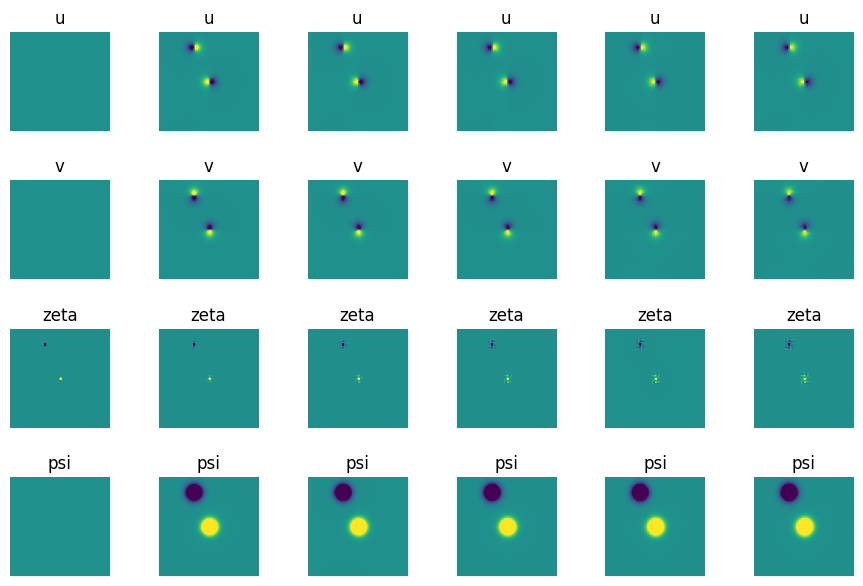

In [229]:
import matplotlib.pyplot as plt
from jax import random

u = jnp.zeros((nx, ny), dtype=jnp.float32)
v = jnp.zeros((nx, ny), dtype=jnp.float32)

zeta = jnp.zeros((nx, ny), dtype=jnp.float32)
psi = jnp.zeros((nx, ny), dtype=jnp.float32)

# some vortices
zeta = zeta.at[32, 32].set(10.0)
zeta = zeta.at[10, 22].set(-10.0)

S = jnp.stack([zeta, psi], axis=-1)

n_view = 6
fig, axs = plt.subplots(4, n_view, figsize=(n_view*1.5, 6))
fig.tight_layout(pad=0.5)

nx = 64 
ny = 64

dx = 2.0
dy = 2.0
dt = 0.01

nu = 0.4

jacobi_iterations = 32

for i in range(n_view):
    zeta = S[:, :, 0]   
    psi = S[:, :, 1]
    u, v = get_uv(S[:, :, 1], dx, dy)

    axs[0, i].imshow(u, vmin=-1, vmax=1)
    axs[1, i].imshow(v, vmin=-1, vmax=1)
    axs[2, i].imshow(zeta, vmin=-1, vmax=1)
    axs[3, i].imshow(psi, vmin=-1, vmax=1)
    axs[0, i].set_title(f"u")
    axs[1, i].set_title(f"v")
    axs[2, i].set_title(f"zeta")
    axs[3, i].set_title(f"psi")
    axs[0, i].set_axis_off()
    axs[1, i].set_axis_off()
    axs[2, i].set_axis_off()
    axs[3, i].set_axis_off()
    
    for _ in range(200):
        S = simulation_step(S, dx, dy, dt, nu, jacobi_iterations)



In [200]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

S_cache = []

zeta = jnp.zeros((nx, ny), dtype=jnp.float32)
psi = jnp.zeros((nx, ny), dtype=jnp.float32)

zeta = zeta.at[10:20, 10:20].set(1.0)

S = jnp.stack([zeta, psi], axis=2)

S_cache.append(S)

animation_steps = 150
jacobi_iterations = 150

for i in range(animation_steps):
    S = simulation_step(S, dx, dy, dt, nu, jacobi_iterations)
    S_cache.append(S)

fig = plt.figure()

imp = plt.imshow(S_cache[0][:, :, 1], animated=True)
plt.close()

def updatefig(i):
    imp.set_array(S_cache[i][:, :, 1])
    return imp,

ani = animation.FuncAnimation(fig, updatefig, frames=range(animation_steps), interval=50, blit=True)
# js 
HTML(ani.to_jshtml())

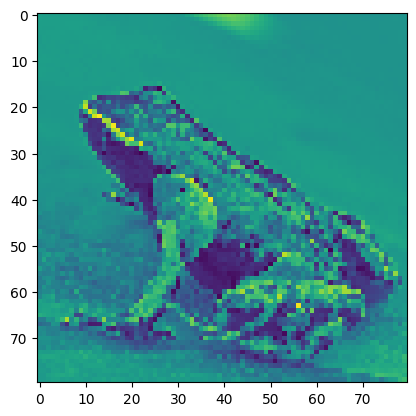

In [156]:
u_target = jnp.array(plt.imread("img/frog.jpg"))
u_target = u_target[0:400 , 150:550, :]
u_target = jnp.mean(u_target, axis=-1)

# downsample to 40 x 40
u_target = u_target[::5, ::5]
nx = u_target.shape[0]
ny = u_target.shape[1]

plt.imshow(u_target)

In [172]:
@partial(jit, static_argnames=("dx", "dy", "dt", "nu", "jacobi_iterations", "animation_steps"))
def animation_loss(
    S0 : jnp.ndarray, 
    target : jnp.ndarray, 
    dt : float, 
    dx : float, 
    dy : float, 
    nu : float,
    jacobi_iterations : int,
    animation_steps : int
) -> float:

    body_fun = lambda i, p_i: simulation_step(p_i, dx, dy, dt, nu, jacobi_iterations)
    
    S = fori_loop(0, animation_steps, body_fun, S0)

    return jnp.mean((S[:, :, 0] - target)**2) + 0.1 * (jnp.max(S[:, :, 0]**2) +  jnp.max(S[:, :, 1]**2) + jnp.max(S[:, :, 2]**2))

loss_and_grad = value_and_grad(animation_loss, argnums=0)

In [173]:
dx = 1.0
dy = 1.0
dt = 0.1

nu = 0.6

S0 = jnp.zeros((nx, ny, 3), dtype=jnp.float32)
S0s = []

optimization_steps = 100
animation_steps = 50
jacobi_iterations = 150

learning_rate = 2

for i in range(optimization_steps):
    S = S0.copy()
    loss, grad = loss_and_grad(S, u_target, dt, dx, dy, nu, jacobi_iterations, animation_steps)

    S0s.append(S0)
    
    S0 = S0 - learning_rate * grad

    print(f"Loss: {loss}")

Loss: 15414.9404296875
Loss: 15396.7822265625
Loss: 15378.6611328125
Loss: 15360.5673828125
Loss: 15342.49609375
Loss: 15324.4404296875
Loss: 15306.3916015625
Loss: 15288.353515625
Loss: 15270.30859375
Loss: 15252.2685546875
Loss: 15234.224609375
Loss: 15216.16796875
Loss: 15198.1103515625
Loss: 15180.0234375
Loss: 15161.9248046875
Loss: 15143.841796875
Loss: 15125.8134765625
Loss: 15107.83984375
Loss: 15089.9140625
Loss: 15072.404296875
Loss: 15054.66796875
Loss: 15037.384765625
Loss: 15023.201171875
Loss: 15014.958984375
Loss: 15014.974609375
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan
Loss: nan